# Training
This notebook trains the model with 3 fold cross validation.

In [1]:
from codecarbon import EmissionsTracker
import logging
output_directory = "/fp/homes01/u01/ec-krimhau/thesis_code/"

tracker = EmissionsTracker(output_dir=output_directory)
tracker.start()

[codecarbon INFO @ 06:58:30] [setup] RAM Tracking...
[codecarbon INFO @ 06:58:30] [setup] GPU Tracking...
[codecarbon INFO @ 06:58:30] Tracking Nvidia GPU via pynvml
[codecarbon INFO @ 06:58:30] [setup] CPU Tracking...
[codecarbon WARNING @ 06:58:30] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon WARNING @ 06:58:32] We saw that you have a AMD EPYC 7452 32-Core Processor but we don't know it. Please contact us.
[codecarbon INFO @ 06:58:32] CPU Model on constant consumption mode: AMD EPYC 7452 32-Core Processor
[codecarbon INFO @ 06:58:32] >>> Tracker's metadata:
[codecarbon INFO @ 06:58:32]   Platform system: Linux-5.14.0-284.30.1.el9_2.x86_64-x86_64-with-glibc2.34
[codecarbon INFO @ 06:58:32]   Python version: 3.11.3
[codecarbon INFO @ 06:58:32]   CodeCarbon version: 2.3.4
[codecarbon INFO @ 06:58:32]   Available RAM : 64.000 GB
[codecarbon INFO @ 06:58:32]   CPU count: 24
[codecarbon INFO @ 06:58:32]   CPU model: AMD EPYC 7452 32-Core Processor
[codecarbon 

In [2]:
logging.getLogger('codecarbon').setLevel(logging.WARNING)

# Imports and setup

In [3]:
import sys
# Need this to load the packages correc in Fox ml nodes.
sys.path.append("/fp/homes01/u01/ec-krimhau/.local/lib/python3.11/site-packages")

In [4]:
import os
import gc
import copy
import time
import random
import string
import joblib

# For data manipulation
import numpy as np
import pandas as pd

# Pytorch Imports
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import Dataset, DataLoader

# Utils
from tqdm import tqdm
from collections import defaultdict

# Sklearn Imports
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GroupKFold, KFold

# For Transformer Models
from transformers import AutoTokenizer, AutoModel, AutoConfig, AdamW
from transformers import DataCollatorWithPadding
import datasets
# For colored terminal text
from colorama import Fore, Back, Style
b_ = Fore.BLUE
y_ = Fore.YELLOW
sr_ = Style.RESET_ALL

# Suppress warnings
import warnings
warnings.filterwarnings("ignore")

# For descriptive error messages
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

import wandb

In [5]:
# Load .env file
%load_ext dotenv
%dotenv /fp/homes01/u01/ec-krimhau/thesis_code/.env

In [6]:

# Get wandb api key from .env file
wandb_api_key = os.getenv('WANDB_API_KEY')
# Login to wandb to track results
wandb.login(key = wandb_api_key) # API key

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: haugerud-kristian (krimhau). Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /fp/homes01/u01/ec-krimhau/.netrc


True

In [7]:
# Function to generate a unique random identifier for experiment tracking.
def id_generator(size=12, chars=string.ascii_lowercase + string.digits):
    return ''.join(random.SystemRandom().choice(chars) for _ in range(size))


HASH_NAME = id_generator(size=12)
print(HASH_NAME)

laqb58zlz0e3


In [8]:
# Config for the model
CONFIG = {"seed": 42,
          "epochs": 3,
          "model_name": "distilbert/distilbert-base-uncased-finetuned-sst-2-english",
          "train_batch_size": 8,
          "valid_batch_size": 16,
          "max_length": 512,
          "learning_rate": 1e-5,
          "scheduler": 'CosineAnnealingLR',
          "min_lr": 1e-6,
          "T_max": 500,
          "weight_decay": 1e-6,
          "n_fold": 3,
          "n_accumulate": 1,
          "num_classes": 3,
          "device": torch.device("cuda:0" if torch.cuda.is_available() else "cpu"),
          "hash_name": HASH_NAME,
          "_wandb_kernel": "deb",
          }

CONFIG["tokenizer"] = AutoTokenizer.from_pretrained(CONFIG['model_name'])
CONFIG['group'] = f'{HASH_NAME}-Baseline'


In [9]:
def set_seed(seed=42):
    '''Sets the seed of the entire notebook so results are the same every time we run.
    This is for REPRODUCIBILITY.'''
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    # When running on the CuDNN backend, two further options must be set
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    # Set a fixed value for the hash seed
    os.environ['PYTHONHASHSEED'] = str(seed)
    
set_seed(CONFIG['seed'])

In [10]:
# Splits the data into train and test. Validation is done using KFold.
def train_test_split(df, train_percent=.85, seed=42):
    np.random.seed(seed)
    perm = np.random.permutation(df.index)
    m = len(df.index)
    train_end = int(train_percent * m)
    train = df.iloc[perm[:train_end]]
    test = df.iloc[perm[train_end:]]
    return train, test

In [11]:
file_path = "/fp/projects01/ec307/ec-krimhau/github_datasets"
file_name = "high_vs_med_low_clean_balanced_github.csv"
full_name = f"{file_path}/{file_name}"
!ls /fp/projects01/ec307/ec-krimhau/github_datasets

clean_github_repos_with_priority_issues.csv  HP_vs_med_low  HP_vs_rest_testset
combined_all_issues_github.csv		     HP_vs_not_HP
high_vs_med_low_clean_balanced_github.csv    HP_vs_rest


In [12]:
import pandas as pd
priority_df = pd.read_csv(full_name , index_col = 0)
priority_df

,text
label,
0,endpoint reset verification status describe th...
0,get homepage ad returns a random product that ...
2,enable hijack exporting in pdf or similar form...
2,create in readmereleasetxt platformscompilers ...
0,setvfo getvfo not working vfo selection proble...
...,...
0,openstreetmaporg isnt accessible firbidden gen...
2,add hillshading layer to openstreetmaporg i pr...
1,give users more control of browser the new bro...


In [13]:
# Drop NaN values and reset index of dataframe
priority_df = priority_df[priority_df['text'].notna()]

priority_df = priority_df.reset_index()


In [14]:
priority_df

,label,text
0,0,endpoint reset verification status describe th...
1,0,get homepage ad returns a random product that ...
2,2,enable hijack exporting in pdf or similar form...
3,2,create in readmereleasetxt platformscompilers ...
4,0,setvfo getvfo not working vfo selection proble...
...,...,...
545767,0,openstreetmaporg isnt accessible firbidden gen...
545768,2,add hillshading layer to openstreetmaporg i pr...
545769,1,give users more control of browser the new bro...
545770,0,daos verbsrxm server crash when client compile...


In [15]:
train_hp_df , test_hp_df = train_test_split(priority_df)

In [16]:
df = train_hp_df

In [17]:
df.reset_index(inplace = True)

In [18]:
df.drop(columns=["index"], inplace=True)

In [19]:
df

,label,text
0,2,include qt plugins for wind and statical build...
1,2,testsci os mgmt infonet test no console output...
2,2,quick exportcsv all attributes menu stays afte...
3,2,optimization remove unused attempt ancestors o...
4,2,dates for experimental conditions set on expri...
...,...,...
463901,2,optional join query parameter to enable server...
463902,0,allow as a valid replication factor as of the ...
463903,0,иногда зацикливается скачивание файла from on ...
463904,0,use nmstatenetworkmanager to set vlanfiltering...


In [20]:
gkf = GroupKFold(n_splits=CONFIG['n_fold'])

for fold, ( _, val_) in enumerate(gkf.split(X=df, groups=df.text)):
    df.loc[val_ , "kfold"] = int(fold)
    
df["kfold"] = df["kfold"].astype(int)


In [21]:
df.groupby('kfold')['label'].value_counts()


kfold  label
0      2        51616
       0        51549
       1        51471
1      1        51729
       0        51492
       2        51414
2      1        51683
       2        51665
       0        51287
Name: count, dtype: int64

In [22]:
df

,label,text,kfold
0,2,include qt plugins for wind and statical build...,1
1,2,testsci os mgmt infonet test no console output...,2
2,2,quick exportcsv all attributes menu stays afte...,1
3,2,optimization remove unused attempt ancestors o...,2
4,2,dates for experimental conditions set on expri...,2
...,...,...,...
463901,2,optional join query parameter to enable server...,0
463902,0,allow as a valid replication factor as of the ...,1
463903,0,иногда зацикливается скачивание файла from on ...,1
463904,0,use nmstatenetworkmanager to set vlanfiltering...,1


In [23]:
class HP_Dataset(Dataset):
    def __init__(self, df, tokenizer, max_length):
        self.df = df
        self.max_len = max_length
        self.tokenizer = tokenizer
        self.text = df['text'].values
        self.targets = df['label'].values
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):
        text = self.text[index]
        inputs = self.tokenizer.encode_plus(
                        text,
                        truncation=True,
                        add_special_tokens=True,
                        max_length=self.max_len
                    )
        
        return {
            'input_ids': inputs['input_ids'],
            'attention_mask': inputs['attention_mask'],
            'target': self.targets[index]
        }

In [24]:
collate_fn = DataCollatorWithPadding(tokenizer=CONFIG['tokenizer'])


In [25]:
class MeanPooling(nn.Module):
    def __init__(self):
        super(MeanPooling, self).__init__()
        
    def forward(self, last_hidden_state, attention_mask):
        input_mask_expanded = attention_mask.unsqueeze(-1).expand(last_hidden_state.size()).float()
        sum_embeddings = torch.sum(last_hidden_state * input_mask_expanded, 1)
        sum_mask = input_mask_expanded.sum(1)
        sum_mask = torch.clamp(sum_mask, min=1e-9)
        mean_embeddings = sum_embeddings / sum_mask
        return mean_embeddings

In [26]:
class HP_Model(nn.Module):
    def __init__(self, model_name):
        super(HP_Model, self).__init__()
        self.model = AutoModel.from_pretrained(model_name)
        self.config = AutoConfig.from_pretrained(model_name)
        self.drop = nn.Dropout(p=0.2)
        self.pooler = MeanPooling()
        self.fc = nn.Linear(self.config.hidden_size, CONFIG['num_classes'])
        
    def forward(self, ids, mask):        
        out = self.model(input_ids=ids,attention_mask=mask,
                         output_hidden_states=False)
        out = self.pooler(out.last_hidden_state, mask)
        out = self.drop(out)
        outputs = self.fc(out)
        return outputs

In [27]:
def criterion(outputs, labels):
    return nn.CrossEntropyLoss()(outputs, labels)

In [28]:
def train_one_epoch(model, optimizer, scheduler, dataloader, device, epoch):
    model.train()
    
    dataset_size = 0
    running_loss = 0.0
    
    bar = tqdm(enumerate(dataloader), total=len(dataloader))
    for step, data in bar:
        ids = data['input_ids'].to(device, dtype = torch.long)
        mask = data['attention_mask'].to(device, dtype = torch.long)
        targets = data['target'].to(device, dtype=torch.long)
        
        batch_size = ids.size(0)

        outputs = model(ids, mask)
        
        loss = criterion(outputs, targets)
        loss = loss / CONFIG['n_accumulate']
        loss.backward()
    
        if (step + 1) % CONFIG['n_accumulate'] == 0:
            optimizer.step()

            # zero the parameter gradients
            optimizer.zero_grad()

            if scheduler is not None:
                scheduler.step()
                
        running_loss += (loss.item() * batch_size)
        dataset_size += batch_size
        
        epoch_loss = running_loss / dataset_size
        
        bar.set_postfix(Epoch=epoch, Train_Loss=epoch_loss,
                        LR=optimizer.param_groups[0]['lr'])
    gc.collect()
    
    return epoch_loss

In [29]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score



In [30]:
def all_classification_report(y_true, y_pred, target_names=['High', 'Medium', 'Low'], digits=4):
    
    print('Classification Report:')
    print(classification_report(y_true, y_pred, target_names=target_names, digits=digits))
    
    accuracy = round(accuracy_score(y_true, y_pred), 4)
    print("Accuracy =", accuracy)
    f1score = round(f1_score(y_true, y_pred, average='weighted'), 4)  # Use 'weighted' for multi-class scenario
    print("F1 Score =", f1score)

    cm = confusion_matrix(y_true, y_pred, labels=[0, 1, 2])  # Update labels to match classes
    ax = plt.subplot()
    sns.heatmap(cm, annot=True, ax=ax, cmap='Blues', fmt="d")
    
    ax.set_title('Confusion Matrix')
    ax.set_xlabel('Predicted Labels')
    ax.set_ylabel('True Labels')
    ax.xaxis.set_ticklabels(target_names)
    ax.yaxis.set_ticklabels(target_names)
    
    plt.show()  # Display the plot
    
    return accuracy, f1score
    

In [31]:
@torch.no_grad()
def valid_one_epoch(model, dataloader, device, epoch):
    model.eval()
    dataset_size = 0
    running_loss = 0.0
    
    y_pred = []
    y_true = []
    
    bar = tqdm(enumerate(dataloader), total=len(dataloader))
    for step, data in bar:        
        ids = data['input_ids'].to(device, dtype = torch.long)
        mask = data['attention_mask'].to(device, dtype = torch.long)
        targets = data['target'].to(device, dtype=torch.long)
        
        batch_size = ids.size(0)

        outputs = model(ids, mask)
        
        loss = criterion(outputs, targets)
        

        predictions = torch.argmax(outputs, dim=-1).flatten().tolist()
        
        target = targets.tolist()

        y_pred.extend(predictions)
        y_true.extend(target)
        running_loss += (loss.item() * batch_size)
        dataset_size += batch_size
        
        epoch_loss = running_loss / dataset_size
        
        bar.set_postfix(Epoch=epoch, Valid_Loss=epoch_loss,LR=optimizer.param_groups[0]['lr'])   
    
    
    accuracy, f1score = all_classification_report(y_true,y_pred)
    gc.collect()
    
    return epoch_loss , accuracy , f1score

In [32]:
def run_training(model, optimizer, scheduler, device, num_epochs, fold):
    # To automatically log gradients
    wandb.watch(model, log_freq=100)
    
    if torch.cuda.is_available():
        print("[INFO] Using GPU: {}\n".format(torch.cuda.get_device_name()))
    
    start = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_epoch_loss = np.inf
    history = defaultdict(list)
    
    for epoch in range(1, num_epochs + 1): 
        gc.collect()
        train_epoch_loss = train_one_epoch(model, optimizer, scheduler, 
                                           dataloader=train_loader, 
                                           device=CONFIG['device'], epoch=epoch)
        
        val_epoch_loss, accuracy , f1score = valid_one_epoch(model, valid_loader, device=CONFIG['device'], 
                                         epoch=epoch)
    
        history['Train Loss'].append(train_epoch_loss)
        history['Valid Loss'].append(val_epoch_loss)
      
        history['Valid accuracy'].append(accuracy)
        history['Valid f1score'].append(f1score)



        
        # Log the metrics
        wandb.log({"Train Loss": train_epoch_loss})
        wandb.log({"Valid Loss": val_epoch_loss})
        wandb.log({"Valid Accuracy": accuracy})
        wandb.log({"Valid F1_score": f1score})


        
        # deep copy the model
        if val_epoch_loss <= best_epoch_loss:
            print(f"{b_}Validation Loss Improved ({best_epoch_loss} ---> {val_epoch_loss})")
            best_epoch_loss = val_epoch_loss
            run.summary["Best Loss"] = best_epoch_loss
            best_model_wts = copy.deepcopy(model.state_dict())
            PATH = f"{HASH_NAME}-Loss-Fold-{fold}.bin"
            torch.save(model.state_dict(), PATH)
            # Save a model file from the current directory
            print(f"Model Saved{sr_}")
            
        print()
    
    end = time.time()
    time_elapsed = end - start
    print('Training complete in {:.0f}h {:.0f}m {:.0f}s'.format(
        time_elapsed // 3600, (time_elapsed % 3600) // 60, (time_elapsed % 3600) % 60))
    print("Best Loss: {:.4f}".format(best_epoch_loss))
    
    # load best model weights
    model.load_state_dict(best_model_wts)
    
    return model, history


In [33]:
def prepare_loaders(fold):
    df_train = df[df.kfold != fold].reset_index(drop=True)
    df_valid = df[df.kfold == fold].reset_index(drop=True)
    
    train_dataset = HP_Dataset(df_train, tokenizer=CONFIG['tokenizer'], max_length=CONFIG['max_length'])
    valid_dataset = HP_Dataset(df_valid, tokenizer=CONFIG['tokenizer'], max_length=CONFIG['max_length'])

    train_loader = DataLoader(train_dataset, batch_size=CONFIG['train_batch_size'], collate_fn=collate_fn, 
                              num_workers=2, shuffle=True, pin_memory=True, drop_last=True)
    valid_loader = DataLoader(valid_dataset, batch_size=CONFIG['valid_batch_size'], collate_fn=collate_fn,
                              num_workers=2, shuffle=False, pin_memory=True)
    
    return train_loader, valid_loader

In [34]:
def fetch_scheduler(optimizer):
    if CONFIG['scheduler'] == 'CosineAnnealingLR':
        scheduler = lr_scheduler.CosineAnnealingLR(optimizer,T_max=CONFIG['T_max'], 
                                                   eta_min=CONFIG['min_lr'])
    elif CONFIG['scheduler'] == 'CosineAnnealingWarmRestarts':
        scheduler = lr_scheduler.CosineAnnealingWarmRestarts(optimizer,T_0=CONFIG['T_0'], 
                                                             eta_min=CONFIG['min_lr'])
    elif CONFIG['scheduler'] == None:
        return None
        
    return scheduler

====== Fold: 0 ======


[INFO] Using GPU: NVIDIA GeForce RTX 3090



100%|██████████| 9665/9665 [08:00<00:00, 20.11it/s, Epoch=1, LR=3.04e-6, Valid_Loss=0.906]


Classification Report:
              precision    recall  f1-score   support

        High     0.5355    0.6452    0.5853     51549
      Medium     0.6623    0.3743    0.4783     51471
         Low     0.5184    0.6371    0.5716     51616

    accuracy                         0.5523    154636
   macro avg     0.5721    0.5522    0.5451    154636
weighted avg     0.5720    0.5523    0.5451    154636

Accuracy = 0.5523
F1 Score = 0.5451


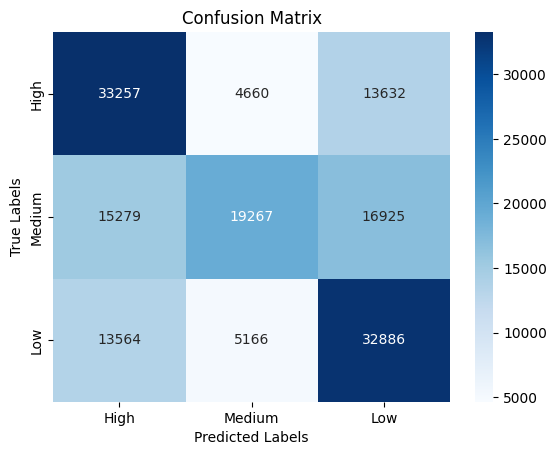

Validation Loss Improved (inf ---> 0.9059326803416886)
Model Saved



100%|██████████| 9665/9665 [08:00<00:00, 20.09it/s, Epoch=2, LR=3.69e-6, Valid_Loss=0.881]


Classification Report:
              precision    recall  f1-score   support

        High     0.5534    0.6477    0.5968     51549
      Medium     0.5785    0.5160    0.5454     51471
         Low     0.5817    0.5453    0.5629     51616

    accuracy                         0.5697    154636
   macro avg     0.5712    0.5697    0.5684    154636
weighted avg     0.5712    0.5697    0.5684    154636

Accuracy = 0.5697
F1 Score = 0.5684


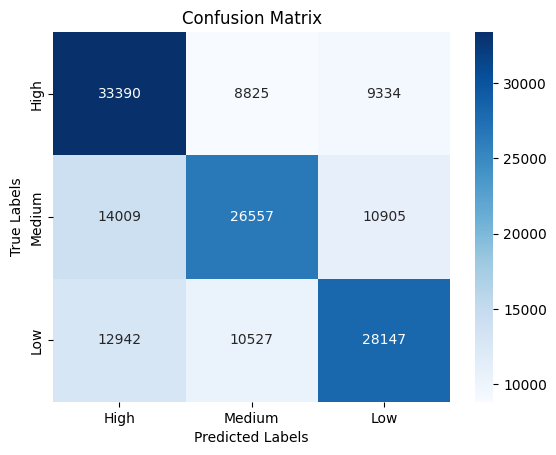

Validation Loss Improved (0.9059326803416886 ---> 0.8809060738584951)
Model Saved



100%|██████████| 9665/9665 [08:01<00:00, 20.06it/s, Epoch=3, LR=9.94e-6, Valid_Loss=0.889]


Classification Report:
              precision    recall  f1-score   support

        High     0.5864    0.5935    0.5899     51549
      Medium     0.6166    0.4955    0.5495     51471
         Low     0.5485    0.6493    0.5946     51616

    accuracy                         0.5795    154636
   macro avg     0.5838    0.5794    0.5780    154636
weighted avg     0.5838    0.5795    0.5780    154636

Accuracy = 0.5795
F1 Score = 0.578


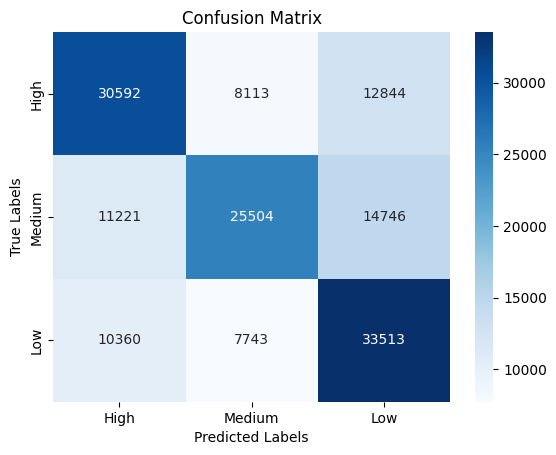


Training complete in 3h 5m 23s
Best Loss: 0.8809


Train Loss,█▄▁
Valid Accuracy,▁▅█
Valid F1_score,▁▆█
Valid Loss,█▁▃
Best Loss,0.88091
Train Loss,0.81211
Valid Accuracy,0.5795
Valid F1_score,0.578
Valid Loss,0.88875



====== Fold: 1 ======


[INFO] Using GPU: NVIDIA GeForce RTX 3090



100%|██████████| 9665/9665 [07:59<00:00, 20.14it/s, Epoch=1, LR=3.04e-6, Valid_Loss=0.908]


Classification Report:
              precision    recall  f1-score   support

        High     0.5575    0.5722    0.5648     51492
      Medium     0.5749    0.4734    0.5192     51729
         Low     0.5289    0.6090    0.5661     51414

    accuracy                         0.5513    154635
   macro avg     0.5538    0.5515    0.5500    154635
weighted avg     0.5538    0.5513    0.5500    154635

Accuracy = 0.5513
F1 Score = 0.55


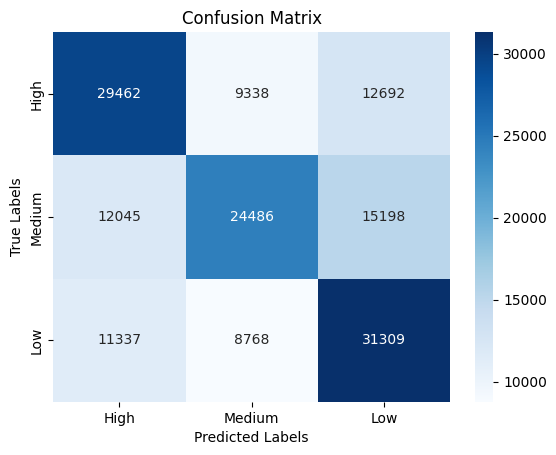

Validation Loss Improved (inf ---> 0.9077199779742634)
Model Saved



 62%|██████▏   | 24093/38658 [33:22<18:43, 12.97it/s, Epoch=2, LR=5.56e-6, Train_Loss=0.879] 

In [ ]:
for fold in range(0, CONFIG['n_fold']):
    print(f"{y_}====== Fold: {fold} ======{sr_}")
    run = wandb.init(project='HP_results_Jira_High_vs_rest_results', 
                     config=CONFIG,
                     job_type='Train',
                     group=CONFIG['group'],
                     tags=[CONFIG['model_name'], f'{HASH_NAME}'],
                     name=f'{HASH_NAME}-fold-{fold}',
                     anonymous='must')
    
    # Create Dataloaders
    train_loader, valid_loader = prepare_loaders(fold=fold)
    
    model = HP_Model(CONFIG['model_name'])
    model.to(CONFIG['device'])
    
    # Define Optimizer and Scheduler
    optimizer = AdamW(model.parameters(), lr=CONFIG['learning_rate'], weight_decay=CONFIG['weight_decay'])
    scheduler = fetch_scheduler(optimizer)
    
    model, history = run_training(model, optimizer, scheduler,
                                  device=CONFIG['device'],
                                  num_epochs=CONFIG['epochs'],
                                  fold=fold)
    
    run.finish()
    
    del model, history, train_loader, valid_loader
    _ = gc.collect()
    print()

<h2> Testing Inference </h2>


In [ ]:
import warnings,transformers,logging,torch

warnings.simplefilter('ignore')
logging.disable(logging.WARNING)

In [ ]:
test_df = test_hp_df

In [ ]:
test_df

In [ ]:
class HP_TestDataset(Dataset):
    def __init__(self, df, tokenizer, max_length):
        self.df = df
        self.max_len = max_length
        self.tokenizer = tokenizer
        self.text = df['text'].values
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):
        text = self.text[index]
        inputs = self.tokenizer.encode_plus(
                        text,
                        truncation=True,
                        add_special_tokens=True,
                        max_length=self.max_len
                    )
        
        samples = {
            'input_ids': inputs['input_ids'],
            'attention_mask': inputs['attention_mask'],
            
        }

        if 'token_type_ids' in inputs:
            samples['token_type_ids'] = inputs['token_type_ids']
        
        return samples

In [ ]:
collate_fn = DataCollatorWithPadding(tokenizer=CONFIG['tokenizer'])

softmax = nn.Softmax(dim=1)
model = HP_Model(CONFIG['model_name'])

In [ ]:
def prepare_test_loader(test_df):    
    test_dataset = HP_TestDataset(test_df, 
                                   tokenizer=CONFIG['tokenizer'], 
                                   max_length=CONFIG['max_length'])
    
    test_loader = DataLoader(test_dataset, 
                             batch_size=CONFIG['valid_batch_size'], 
                             collate_fn=collate_fn, 
                             num_workers=2, 
                             shuffle=False, 
                             pin_memory=True, 
                             drop_last=False)
    return test_loader

test_loader = prepare_test_loader(test_df)

In [ ]:
triceps@torch.no_grad()
def inference(test_loader, model, device):
    preds = []
    preds_target = []
    model.eval()
    model.to(device)
    
    bar = tqdm(enumerate(test_loader), total=len(test_loader))
    
    for step, data in bar: 
        ids = data['input_ids'].to(device, dtype = torch.long)
        mask = data['attention_mask'].to(device, dtype = torch.long)
        
        output = model(ids, mask)
        y_preds = softmax(torch.tensor(output.to('cpu'))).numpy()
        pred_target = torch.argmax(output, dim=-1).flatten().tolist()
        
        preds.append(y_preds)
        preds_target.append(pred_target) 
    predictions = np.concatenate(preds)
    predictions_label = np.concatenate(preds_target)
    return predictions , predictions_label

In [ ]:
deberta_predictions = []
deberta_predictions_labels = []



for fold in range(0, CONFIG['n_fold']):
    print("Fold {}".format(fold))
    
    state = torch.load(f'{HASH_NAME}-Loss-Fold-{fold}.bin')
    model.load_state_dict(state)
    
    prediction, predictions_label = inference(test_loader, model, CONFIG['device'])
    deberta_predictions.append(prediction)
    deberta_predictions_labels.append(predictions_label)
    del state, prediction; gc.collect()
    torch.cuda.empty_cache()
del model

In [ ]:
deberta_predictions


In [ ]:
predictions = np.mean(deberta_predictions, axis=0)
predictions

In [ ]:
len(predictions)

In [ ]:
predictions

In [ ]:
test_df["prediction_0"] = predictions[:, 0] 

In [ ]:
test_df["prediction_1"] = predictions[:, 1] 

In [ ]:
test_df["prediction_2"] = predictions[:, 2] 

In [ ]:
for i in range(0, CONFIG['n_fold']):

    test_df[f"prediction_label_fold_{i}"] = deberta_predictions_labels[i]


In [ ]:
test_df

In [ ]:
len(test_df)

In [ ]:
test_df['Max'] = test_df[['prediction_0','prediction_1', 'prediction_2']].idxmax(axis=1)

In [ ]:
test_df

In [ ]:
test_df['pred'] = test_df['Max'].map({
    'prediction_0': 0,
    'prediction_1': 1,
    'prediction_2': 2
})
test_df

In [ ]:
test_df

In [ ]:
from sklearn.metrics import confusion_matrix
cf_matrix = confusion_matrix(test_df["label"].values, test_df["pred"].values)

print(cf_matrix)

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Define label names
label_names = ['low', 'medium', 'high']

# Plot heatmap with new labels
ax = sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, 
                 fmt='.2%', cmap='Blues')

# Set title and axis labels
ax.set_title('Jira: Highest vs rest\n\n NonHP vs HP \n\n')
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values')

# Set tick labels using defined label names
ax.xaxis.set_ticklabels(label_names)
ax.yaxis.set_ticklabels(label_names)

# Display the visualization of the Confusion Matrix
plt.show()


In [ ]:
from sklearn.metrics import classification_report


print(classification_report(test_df["label"].values, test_df["pred"].values))

In [ ]:
tracker.stop()